In [7]:
import cv2, sys, os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')
from Scripts.iris_recognition import *

In [17]:
def load_keypoints(recognizer, rois, show=False, show_pos: list = ['right-side','left-side','bottom']):
    bf = cv2.BFMatcher()


    for pos in ['right-side','left-side','bottom','complete']:
        # cv2.imshow(f"rois['{pos}']['img_kp_init'] Before", rois[pos]['img_kp_init'])
        # for i, kp in enumerate(rois[pos]['kp'][0:2]):
        #     print(f"KeyPoint {i}:")
        #     print(f"  - Position (x, y): ({kp.pt[0]}, {kp.pt[1]})")
        #     print(f"  - Size: {kp.size}")
        #     print(f"  - Angle: {kp.angle}")
        #     print(f"  - Response: {kp.response}")
        #     print(f"  - Octave: {kp.octave}")
        #     print(f"  - Class ID: {kp.class_id}")
        # Create image with non-filtered keypoints
        rois[pos]['img_kp_init'] = cv2.drawKeypoints(
                                        rois[pos]['img'], rois[pos]['kp'],
                                        color=(0,255,0), flags=0,
                                        outImage=None)
        # cv2.imshow(f"rois['{pos}']['img_kp_init'] After", rois[pos]['img_kp_init'])
        cv2.circle(
            rois[pos]['img_kp_init'],
            (rois[pos]['pupil_circle'][0], rois[pos]['pupil_circle'][1]),
            rois[pos]['pupil_circle'][2], (0,0,255), 1)
        cv2.circle(
            rois[pos]['img_kp_init'],
            (rois[pos]['ext_circle'][0], rois[pos]['ext_circle'][1]),
            rois[pos]['ext_circle'][2], (0,255,255), 1)


        # Filter detected keypoints
        inside = 0
        outside = 0
        wrong_angle = 0
        if pos == 'complete' : rois['kp_len'] = len(rois[pos]['kp'])
        kp_list = list(rois[pos]['kp'][:])
        for kp in kp_list:
            c_angle = recognizer.angle_v(rois[pos]['ext_circle'][0],
                            rois[pos]['ext_circle'][1],
                            kp.pt[0], kp.pt[1])
            if recognizer.point_in_circle(rois[pos]['pupil_circle'][0],
                            rois[pos]['pupil_circle'][1],
                            rois[pos]['pupil_circle'][2]+3,
                            kp.pt[0], kp.pt[1]):
                kp_list.remove(kp)
                inside +=1
            elif not recognizer.point_in_circle(rois[pos]['ext_circle'][0],
                                    rois[pos]['ext_circle'][1],
                                    rois[pos]['ext_circle'][2]-5,
                                    kp.pt[0], kp.pt[1]):
                kp_list.remove(kp)
                outside +=1
            elif (pos == 'right-side' and (c_angle <= -45 or c_angle >= 45)) or \
                (pos == 'left-side' and (c_angle <= 135 and c_angle >= -135)) or \
                (pos == 'bottom' and (c_angle <= -135 or c_angle >= -45)):
                kp_list.remove(kp)
                wrong_angle +=1
        rois[pos]['kp'] = tuple(kp_list)
        if pos == 'complete' : rois['kp_filtered_len'] = len(rois[pos]['kp'])

        # Create images with filtered keypoints
        rois[pos]['img_kp_filtered'] = cv2.drawKeypoints(
                                rois[pos]['img'],rois[pos]['kp'],
                                color=(0,255,0), flags=0,
                                outImage=None)
        cv2.circle(
            rois[pos]['img_kp_filtered'],
            (rois[pos]['pupil_circle'][0],rois[pos]['pupil_circle'][1]),
            rois[pos]['pupil_circle'][2], (0,0,255), 1)
        cv2.circle(
            rois[pos]['img_kp_filtered'],
            (rois[pos]['ext_circle'][0],rois[pos]['ext_circle'][1]),
            rois[pos]['ext_circle'][2], (0,255,255), 1)

    # Show keypoints images
    if show:
        i=0
        for pos in show_pos:
            plt.subplot(3, 2, 2*i+1), \
            plt.imshow(rois[pos]['img_kp_init'])
            plt.xticks([]), plt.yticks([])
            plt.subplot(3, 2, 2*i+2), \
            plt.imshow(rois[pos]['img_kp_filtered'])
            plt.xticks([]), plt.yticks([])
            i+=1
        plt.show()

In [18]:
def combine_keypoints_and_descriptors(kp_desc_lists):
    combined_keypoints = []
    combined_descriptors = []
    for kp_list, desc_list in kp_desc_lists:
        combined_keypoints.extend(kp_list)
        combined_descriptors.extend(desc_list)
    return combined_keypoints, np.array(combined_descriptors)

def are_keypoints_similar(kp1, kp2, threshold=1e-3):
    # Calculate Euclidean distance between two keypoints
    distance = np.sqrt((kp1.pt[0] - kp2.pt[0])**2 + (kp1.pt[1] - kp2.pt[1])**2)
    return distance < threshold

def filter_similar_keypoints(keypoints, descriptors, threshold=1e-10):
    unique_keypoints = []
    unique_descriptors = []
    
    for kp, desc in zip(keypoints, descriptors):
        if not any(are_keypoints_similar(kp, ukp, threshold) for ukp in unique_keypoints):
            unique_keypoints.append(kp)
            unique_descriptors.append(desc)
            
    return unique_keypoints, np.array(unique_descriptors)


In [10]:
db_system = IrisSystem(db_name='iris_db_thousand', db_path='../Database/iris_db_thousand')
recognizer = IrisRecognizer()

In [20]:
db_system.db_name

'Database/iris_db_thousand'

In [11]:
rois_1 = db_system.retrieve_iris(feature_tag='S5000R02', get_img=True)
rois_2 = db_system.retrieve_iris(feature_tag='S5000R06', get_img=True)

In [40]:
list_of_keypoints1 = rois_1['complete']['kp']
descriptors1 = rois_1['complete']['des']
list_of_keypoints2 = rois_2['complete']['kp']
descriptors2 = rois_2['complete']['des']

In [23]:
# Example usage
kp_desc_lists = [(list_of_keypoints1, descriptors1), (list_of_keypoints2, descriptors2)]  # Example input
combined_keypoints, combined_descriptors = combine_keypoints_and_descriptors(kp_desc_lists)
filtered_keypoints, filtered_descriptors = filter_similar_keypoints(combined_keypoints, combined_descriptors)

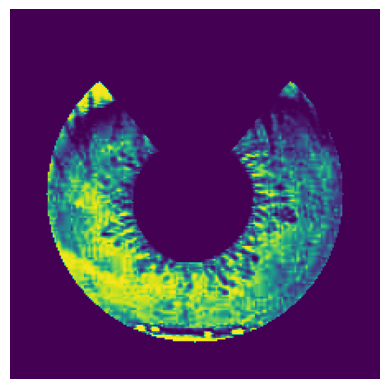

In [24]:
plt.imshow(rois_1['complete']['img'])
plt.axis('off')
plt.show()

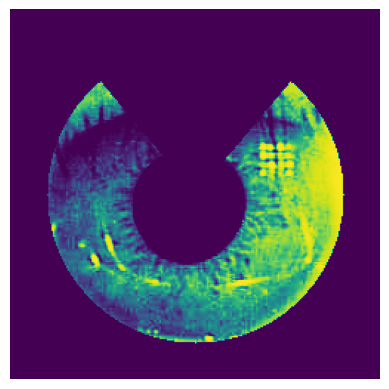

In [25]:
plt.imshow(rois_2['complete']['img'])
plt.axis('off')
plt.show()

In [26]:
sift: cv2.SIFT = cv2.SIFT_create()

In [27]:
def copy_rois(rois1):
    return {
        'right-side': {
            'img': rois_1['complete']['img'],
            'kp': [cv2.KeyPoint(kp.pt[0], kp.pt[1], kp.size, kp.angle, kp.response, kp.octave, kp.class_id) for kp in rois_1['complete']['kp']],
            'des': rois_1['complete']['des'].copy(),
            'pupil_circle': rois_1['complete']['pupil_circle'],
            'ext_circle': rois_1['complete']['ext_circle'],
        },
        'left-side': {
            'img': rois_1['complete']['img'],
            'kp': [cv2.KeyPoint(kp.pt[0], kp.pt[1], kp.size, kp.angle, kp.response, kp.octave, kp.class_id) for kp in rois_1['complete']['kp']],
            'des': rois_1['complete']['des'].copy(),
            'pupil_circle': rois_1['complete']['pupil_circle'],
            'ext_circle': rois_1['complete']['ext_circle'],
        },
        'bottom': {
            'img': rois_1['complete']['img'],
            'kp': [cv2.KeyPoint(kp.pt[0], kp.pt[1], kp.size, kp.angle, kp.response, kp.octave, kp.class_id) for kp in rois_1['complete']['kp']],
            'des': rois_1['complete']['des'].copy(),
            'pupil_circle': rois_1['complete']['pupil_circle'],
            'ext_circle': rois_1['complete']['ext_circle'],
        },
        'complete': {
            'img': rois_1['complete']['img'],
            'kp': [cv2.KeyPoint(kp.pt[0], kp.pt[1], kp.size, kp.angle, kp.response, kp.octave, kp.class_id) for kp in rois_1['complete']['kp']],
            'des': rois_1['complete']['des'].copy(),
            'pupil_circle': rois_1['complete']['pupil_circle'],
            'ext_circle': rois_1['complete']['ext_circle'],
        }
    }    

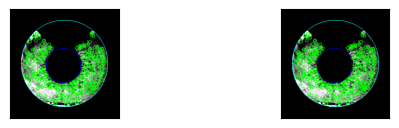

388


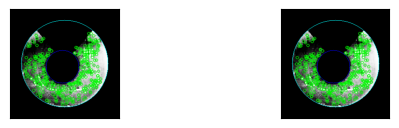

379


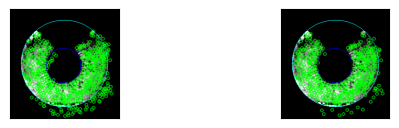

559


In [33]:
load_keypoints(recognizer=recognizer, rois=rois_1, show=True, show_pos=['complete'])
print(len(rois_1['complete']['kp']))

load_keypoints(recognizer=recognizer, rois=rois_2, show=True, show_pos=['complete'])
print(len(rois_2['complete']['kp']))

rois_1_copy = copy_rois(rois_1)
rois_1_copy['complete']['kp'] = tuple(filtered_keypoints)
rois_1_copy['complete']['des'] = tuple(filtered_descriptors)
load_keypoints(recognizer=recognizer, rois=rois_1_copy, show=True, show_pos=['complete'])
print(len(rois_1_copy['complete']['kp']))

In [29]:
def compare_lists(list1, list2):
    """
    Compare two lists and return the differences and common elements.

    Args:
    - list1: First list to compare.
    - list2: Second list to compare.

    Returns:
    - unique_to_list1: Elements unique to list1.
    - unique_to_list2: Elements unique to list2.
    - common_elements: Elements common to both lists.
    """
    set1 = set(list1)
    set2 = set(list2)

    unique_to_list1 = list(set1 - set2)
    unique_to_list2 = list(set2 - set1)
    common_elements = list(set1 & set2)

    return len(unique_to_list1), len(unique_to_list2), len(common_elements)

In [37]:
print(compare_lists(rois_1['complete']['kp'], rois_2['complete']['kp']))
print(compare_lists(rois_1['complete']['kp'], filtered_keypoints))
print(compare_lists(rois_2['complete']['kp'], filtered_keypoints))

(388, 379, 0)
(76, 331, 312)
(69, 333, 310)
